# Train VIAC Model
This notebook will develop and train a neural network to predict the percent change in the VIAC price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'VIAC'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,1.769187,0.201479,0.809468,1.367643,6.396981,0.806636,10.619269,5.796038,6.059593,2.039140,...,0.0,2.0,3.0,0.0,0.500000,0.500000,0.000000,0.400000,0.600000,0.000000
2021-03-02,1.228232,0.214461,0.838925,1.232101,7.553862,0.860812,4.030040,6.581007,5.040566,2.039140,...,0.0,2.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2021-03-03,0.920985,0.217778,0.874603,1.424985,9.936950,0.906573,6.571827,6.917386,5.079229,2.039140,...,1.0,0.0,10.0,3.0,0.000000,0.800000,0.200000,0.000000,0.769231,0.230769
2021-03-04,0.344773,0.235309,0.918495,1.368409,10.398630,0.991601,0.856513,6.588511,4.808860,2.039140,...,0.0,2.0,1.0,0.0,0.500000,0.500000,0.000000,0.666667,0.333333,0.000000
2021-03-05,2.436628,0.255653,0.947427,1.284281,11.937210,1.020370,4.278698,7.042520,4.289022,2.157856,...,1.0,0.0,-15.0,2.0,0.000000,0.500000,0.500000,0.000000,-0.882353,0.117647
2021-03-08,5.858109,0.285221,0.991016,1.373686,28.475938,1.079334,46.431375,16.028045,17.989490,2.157856,...,2.0,0.0,11.0,7.0,0.000000,0.666667,0.333333,0.000000,0.611111,0.388889
2021-03-09,-2.450185,0.271623,0.942777,1.129708,15.817403,0.679610,5.297369,16.040231,8.940814,2.157856,...,0.0,0.0,2.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-10,1.678036,0.302304,0.988763,1.239654,20.150035,0.753982,0.750509,15.528133,-1.246711,2.309281,...,0.0,6.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2021-03-11,1.740467,0.323533,1.034475,1.271296,24.149494,0.824538,10.210305,17.369834,10.357276,2.468207,...,1.0,-1.0,-17.0,3.0,0.333333,0.555556,0.111111,-0.024390,-0.414634,0.073171


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [100]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 10 |periods: 20

Training complete in 0m 2s
Iteration: 80 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 89 |periods: 40|hidden: 100|layers

Training complete in 0m 3s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 7s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 2s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 5s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 6s
Iteration: 169 |periods: 1|hidden: 5

Training complete in 0m 5s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 249 |periods: 10|hidden: 100

Training complete in 0m 7s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 10s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 328 |periods: 20|hidden: 1

Training complete in 0m 2s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 408 |periods: 60|hidden: 50|layers: 2

Training complete in 0m 3s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 2s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 7s
Iteration: 487 

Training complete in 0m 2s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 565 |periods: 1|hidden: 5

Training complete in 0m 4s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 2s
Iteration: 644 |periods: 5|hidden: 100|

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

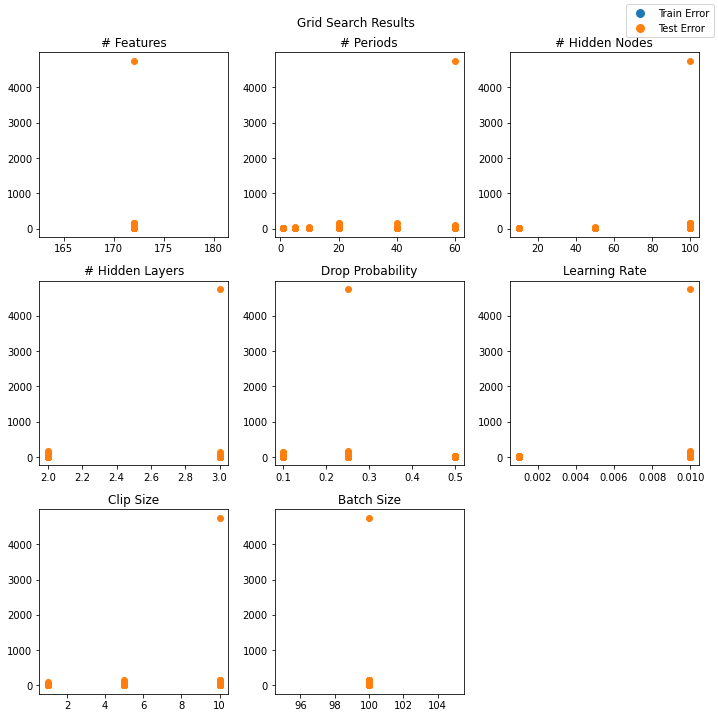

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
262,1.331194,11.765509,172.0,40.0,50.0,2.0,0.25,0.001,5.0,100.0
334,1.642294,12.096739,172.0,40.0,50.0,2.0,0.10,0.010,5.0,100.0
395,1.524590,12.191097,172.0,60.0,100.0,3.0,0.25,0.010,5.0,100.0
124,1.638491,12.231011,172.0,40.0,100.0,2.0,0.10,0.010,1.0,100.0
479,1.351265,12.291497,172.0,60.0,50.0,2.0,0.25,0.001,10.0,100.0
...,...,...,...,...,...,...,...,...,...,...
375,5.375192,140.947342,172.0,20.0,100.0,2.0,0.25,0.010,5.0,100.0
555,14.780312,152.978073,172.0,20.0,100.0,2.0,0.10,0.010,10.0,100.0
574,1.744767,154.730286,172.0,40.0,100.0,3.0,0.10,0.010,10.0,100.0
591,19.964128,167.139526,172.0,20.0,100.0,2.0,0.25,0.010,10.0,100.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 50, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
batch_size = [1,5,10,20,40,60,120,240]
epochs = [10,25,50,100,250,500]

In [18]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 48 different configurations.
Iteration: 1 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 3m 8s
Iteration: 2 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 40s
Iteration: 3 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 21s
Iteration: 4 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 5 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 8s
Iteration: 6 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 7 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 8 |epochs: 10|periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 9 |epochs: 25|p

In [19]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

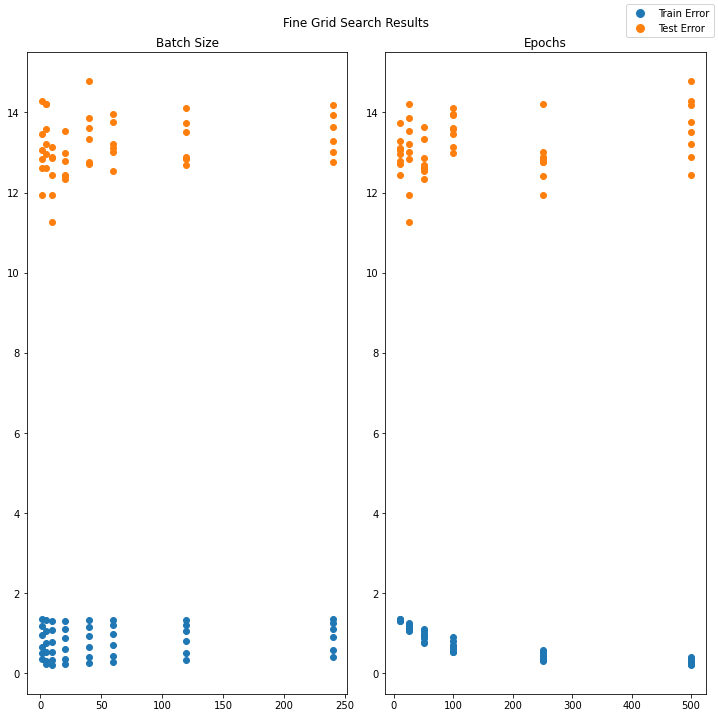

In [20]:
dh.visualizeFineGridSearch(fine_grid_result)

In [21]:
resultdf = dh.resultDFFine(fine_grid_result)

In [22]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
10,1.079101,11.266396,172.0,40.0,50.0,2.0,0.25,0.001,5.0,10.0,25.0
34,0.327035,11.927100,172.0,40.0,50.0,2.0,0.25,0.001,5.0,10.0,250.0
8,1.188052,11.942117,172.0,40.0,50.0,2.0,0.25,0.001,5.0,1.0,25.0
19,0.873982,12.342044,172.0,40.0,50.0,2.0,0.25,0.001,5.0,20.0,50.0
35,0.348665,12.420613,172.0,40.0,50.0,2.0,0.25,0.001,5.0,20.0,250.0
2,1.318906,12.430974,172.0,40.0,50.0,2.0,0.25,0.001,5.0,10.0,10.0
43,0.234476,12.440799,172.0,40.0,50.0,2.0,0.25,0.001,5.0,20.0,500.0
21,0.972855,12.529042,172.0,40.0,50.0,2.0,0.25,0.001,5.0,60.0,50.0
16,0.949630,12.612246,172.0,40.0,50.0,2.0,0.25,0.001,5.0,1.0,50.0
17,0.770988,12.621730,172.0,40.0,50.0,2.0,0.25,0.001,5.0,5.0,50.0


## Evaluate Final Model

In [23]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 50, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

Training RMSE: 0.5103691589292892
Test RMSE: 5.211897239275918
Training MAE: 0.3678980283933862
Test MAE: 3.0388482835095196
Training - Above Error: $0.37 (49.47%) Below Error: $-0.37 (50.53%)
Test - Above Error: $2.51 (35.14%) Below Error: $-3.33 (64.86%)


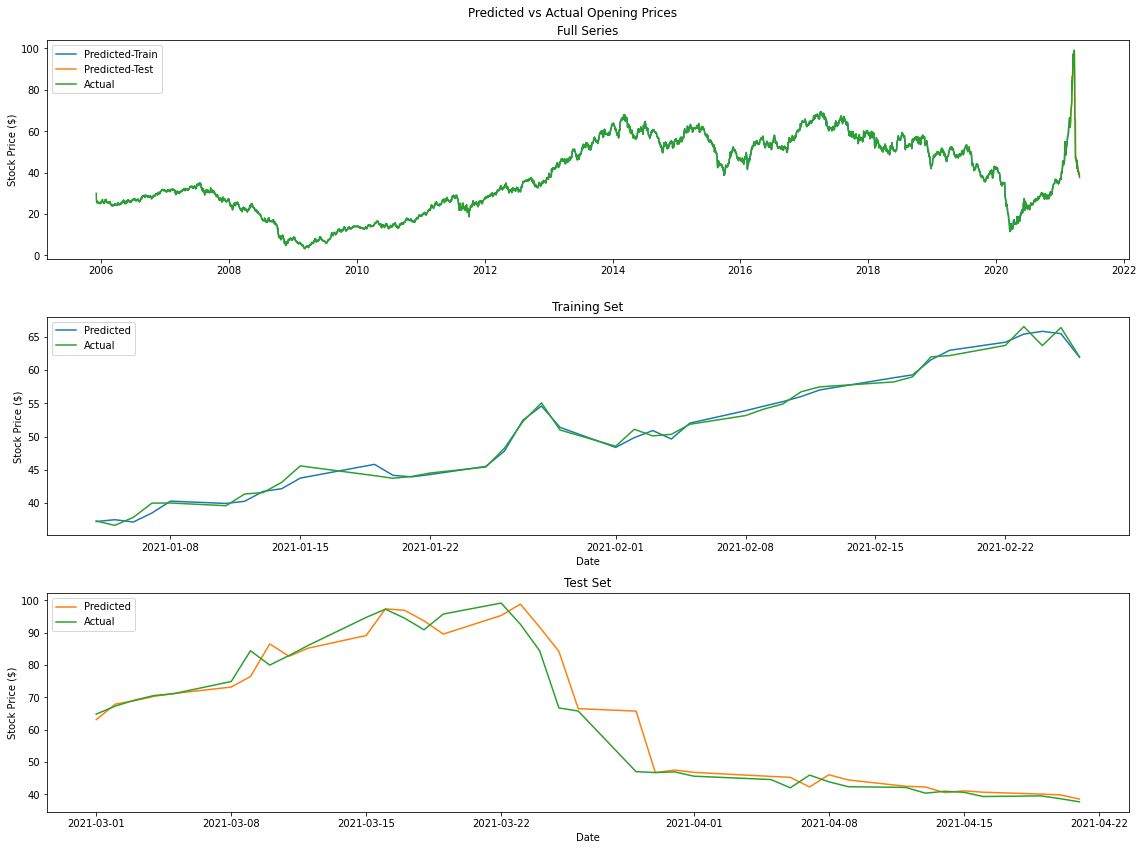

In [24]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [25]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,40.619999,0.000314,Test,41.057088
2021-04-16,39.299999,0.019279,Test,40.632759
2021-04-19,39.500000,0.007733,Test,40.057658
2021-04-20,38.639999,-0.003294,Test,39.805442
2021-04-21,37.650002,0.000174,Test,38.512707


In [26]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [27]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)